# INM702: Task 2

This task is about forecasting daily mean temperatures using data from a weather station near Heathrow Airport in London, UK. The dataset can be found on Kaggle [here](https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data).

We use a recurrent neural network to achieve this, though other techniques include standard statistical methods such as the autoregressive integrated moving average (ARIMA). The implementation is done using PyTorch.

The work presented here is part of the coursework of the INM702 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM702).

### Import Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch

# Import libraries for transforming the data
from sklearn.preprocessing import StandardScaler

# Ignore warnings (making the work easier to read)
import warnings
warnings.filterwarnings("ignore")

### Set Random Seeds

In [2]:
randomer = 50
random.seed(randomer)
np.random.seed(randomer)

### Import Dataset

In [3]:
df = pd.read_csv("london_weather.csv", delimiter = ",")

# Check for duplicate rows or NA values
print(df.isnull().sum(), "\n")
print("How Many Duplicate Rows?", df.duplicated().sum())

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64 

How Many Duplicate Rows? 0


### Data Cleaning

We find that there are NA values for the 'mean_temp' column, which is the one that we will be working with. We decide to fill these NA values with an average of the previous 2 days and of the 2 days after. So the NA mean temperature $c$ is calculated as:

$$c = \frac{a + b + d + e}{4}$$

where $a, b, d, e$ are the 2 days before and after the NA value $c$.

In [4]:
# Calculate the average of the three values above and below the NaN value (convenient method to replace the NaN values)
df["mean_temp_filled"] = df["mean_temp"].fillna(
    (df["mean_temp"].shift(1) + df["mean_temp"].shift(2)
     + df["mean_temp"].shift(-1) + df["mean_temp"].shift(-2)) / 4
)

# Drop old 'mean_temp' column, replace with the new one that filled the NaN values
df.drop(["mean_temp"], axis = 1, inplace = True)
df.rename(columns = {"mean_temp_filled": "mean_temp"}, inplace=True)

df

,date,cloud_cover,sunshine,global_radiation,max_temp,min_temp,precipitation,pressure,snow_depth,mean_temp
0,19790101,2.0,7.0,52.0,2.3,-7.5,0.4,101900.0,9.0,-4.1
1,19790102,6.0,1.7,27.0,1.6,-7.5,0.0,102530.0,8.0,-2.6
2,19790103,5.0,0.0,13.0,1.3,-7.2,0.0,102050.0,4.0,-2.8
3,19790104,8.0,0.0,13.0,-0.3,-6.5,0.0,100840.0,2.0,-2.6
4,19790105,6.0,2.0,29.0,5.6,-1.4,0.0,102250.0,1.0,-0.8
...,...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.6,2.0,98000.0,NaN,7.5
15337,20201228,7.0,3.7,38.0,3.6,-1.3,0.2,97370.0,NaN,1.1
15338,20201229,7.0,0.0,21.0,4.1,1.1,0.0,98830.0,NaN,2.6
15339,20201230,6.0,0.4,22.0,5.6,-0.1,0.0,100200.0,NaN,2.7


In [5]:
print("Are all NA values for 'mean_temp' filled?", df["mean_temp"].isnull().sum() == 0)

Are all NA values for 'mean_temp' filled? True


### Visualise Mean Temperature Data

There are many components that together form a time series. The main two components are trend and seasonality. The trend indicates a long term change of the mean, which is typically modelled using polynomials, splines or exponentials. Seasonality shows a pattern over a certain time period, such as a month or year. Sinusoids are typically used to model seasonality.

We can see from our time series of the daily London Mean Temperature between 1979 and 2020 (inclusive) that seasonality is the most visible component.

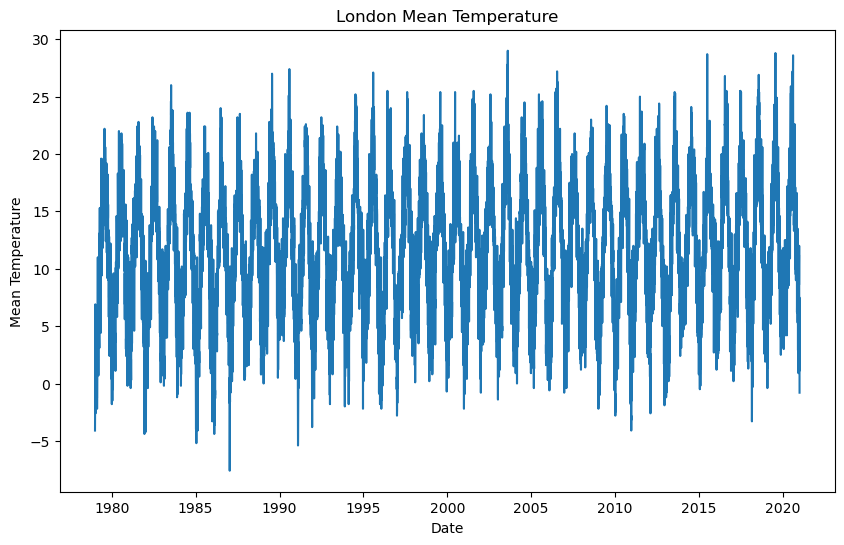

In [6]:
df["date"] = pd.to_datetime(df["date"], format = "%Y%m%d")

dates = df["date"] 
mean_temp = df["mean_temp"]

plt.figure(figsize = (10, 6))
plt.plot(dates, mean_temp)
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.title("London Mean Temperature")
plt.show()

### The Additive Model

There are different ways to model a time series, and we choose the additive model. We consider this because it works with negative values, is easy to interpret and easy to compute.

We model a time series as trend ($m_{t}$) + seasonality ($S_{t}$) + noise ($Y_{t}$):

$$X_{t} = m_{t} + S_{t} + Y_{t}, t = 1, ..., n.$$

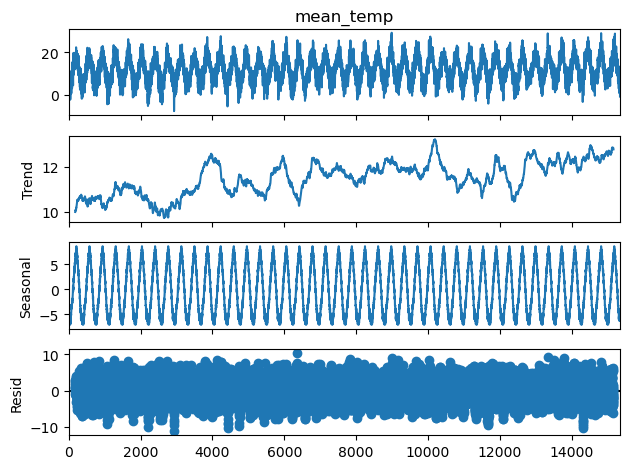

In [7]:
# Use 'statsmodels' library to decompose time series into trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose time series data, over a period of 365 days (a year)
result = seasonal_decompose(mean_temp, model = "additive", period = 365)
result.plot()
plt.show()

### Transforming the Data

Typically in time series analysis, transformations are applied to data in order to stabilise the variance. Common methods include the Box-Cox transformation and the natural logarithm, but we are working with data that can be both negative and positive. We decide to perform simple standardisation on the data for this reason.

In [8]:
# Use 'StandardScaler()' to demean and scale to unit variance (standardise)
y = StandardScaler().fit_transform(np.array(mean_temp).reshape(-1, 1))

y

array([[-2.71911713],
       [-2.45726351],
       [-2.49217732],
       ...,
       [-1.54950428],
       [-1.53204738],
       [-2.14303916]])

### Splitting the Dataset

We are going to try and predict the whole of 2020, which has 366 days (it is a leap year).

In [9]:
n = df.shape[0]
t = n - 366

date_train = dates[0:t]
date_test = dates[t:]

y_train = y[0:t]
y_test = y[t:]

print("Training Shape", y_train.shape)
print("Testing Shape", y_test.shape)

Training Shape (14975, 1)
Testing Shape (366, 1)


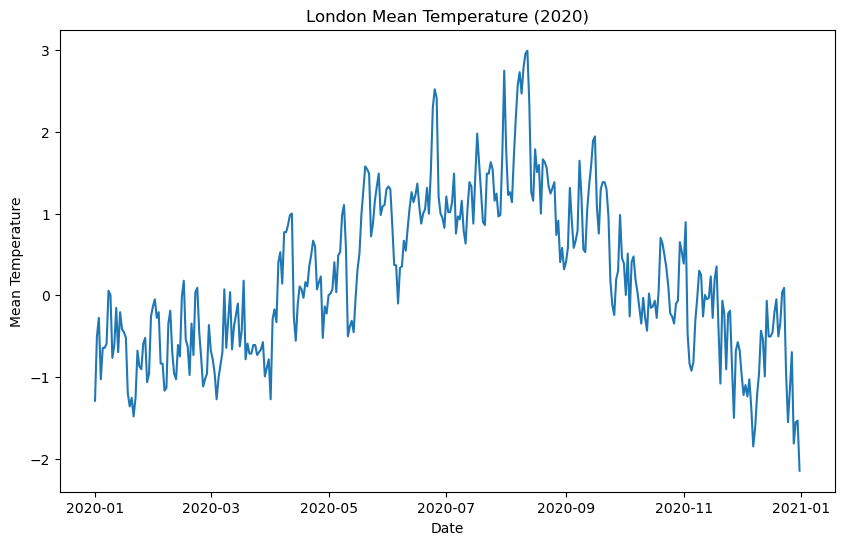

In [10]:
# Plot of 2020 data (standardised)
plt.figure(figsize = (10, 6))
plt.plot(date_test, y_test)
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.title("London Mean Temperature (2020)")
plt.show()

### Check if GPU Exists on Machine

In [11]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cpu
